In [2]:
import pandas as pd
df = pd.read_csv("OnlineRetail.csv" , encoding="latin1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49445 entries, 0 to 49444
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    49445 non-null  object 
 1   StockCode    49445 non-null  object 
 2   Description  49303 non-null  object 
 3   Quantity     49445 non-null  int64  
 4   InvoiceDate  49445 non-null  object 
 5   UnitPrice    49445 non-null  float64
 6   CustomerID   31563 non-null  float64
 7   Country      49444 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.0+ MB


In [4]:
df.isna().sum().sort_values(ascending=False)

,0
CustomerID,17882
Description,142
Country,1
InvoiceNo,0
Quantity,0
StockCode,0
UnitPrice,0
InvoiceDate,0


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,49445.000000,49445.000000,31563.000000
mean,8.315239,6.458260,15423.016823
std,55.832343,167.436019,1753.298111
min,-9360.000000,0.000000,12347.000000
25%,1.000000,1.250000,14051.000000
50%,2.000000,2.510000,15464.000000
75%,8.000000,4.250000,17041.000000
max,2880.000000,16888.020000,18283.000000


In [6]:
df['CustomerID'] = df['CustomerID'].astype("float64")

In [7]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [8]:
df['InvoiceNo'].astype(str).str.startswith('c').value_counts(normalize=True)

,proportion
InvoiceNo,
False,1.0


In [9]:

df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype("int")
print("✅ Data loaded and cleaned. Shape:", df.shape)


✅ Data loaded and cleaned. Shape: (30699, 8)


In [10]:
df = df[df['Quantity'] > 0]


In [11]:
df = df[df['UnitPrice'] > 0]

In [12]:
df['InvoiceDate'].sample(15)


,InvoiceDate
7219,03-12-2010 15:45
17954,08-12-2010 12:46
23856,10-12-2010 12:33
42651,04-01-2011 11:34
319,01-12-2010 11:21
10120,05-12-2010 16:41
33574,16-12-2010 14:36
47193,06-01-2011 18:33
47319,07-01-2011 10:00
8033,05-12-2010 12:08


In [13]:
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    dayfirst=True,
    errors='coerce'
)


In [14]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [15]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-01-10 12:01:00')

In [16]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})


In [17]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12347,33,1,711.79
12348,24,1,892.80
12370,24,2,1868.02
12377,21,1,1001.52
12383,18,1,600.72


In [18]:
rfm.describe()

,Recency,Frequency,Monetary
count,961.000000,961.000000,961.000000
mean,24.703434,1.658689,707.022799
std,11.611887,1.971688,1524.025114
min,1.000000,1.000000,12.450000
25%,21.000000,1.000000,205.640000
50%,27.000000,1.000000,343.260000
75%,33.000000,2.000000,656.700000
max,40.000000,37.000000,27834.610000


In [19]:
(rfm <= 0).sum()


,0
Recency,0
Frequency,0
Monetary,0


In [20]:
print("✅ RFM features computed. Sample:")
print(rfm.head())


✅ RFM features computed. Sample:
            Recency  Frequency  Monetary
CustomerID                              
12347            33          1    711.79
12348            24          1    892.80
12370            24          2   1868.02
12377            21          1   1001.52
12383            18          1    600.72


In [21]:
import numpy as np

rfm_log = np.log1p(rfm)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [23]:
from sklearn.decomposition import PCA

pca = PCA()
rfm_pca = pca.fit_transform(rfm_scaled)

In [24]:
pca.explained_variance_ratio_

array([0.62014495, 0.2525241 , 0.12733095])

In [25]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

In [26]:
rfm_pca.shape


(961, 2)

In [27]:
#             MODELLING

In [28]:
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

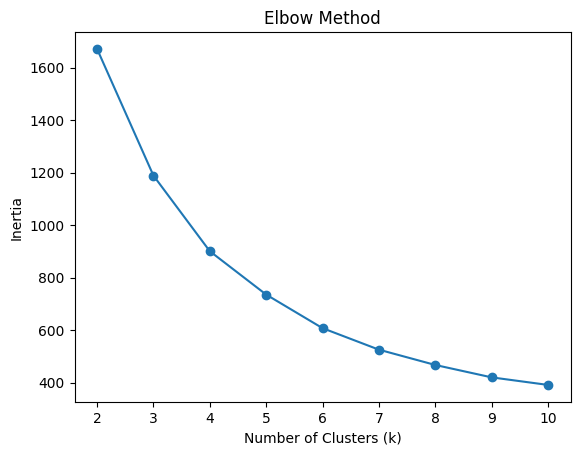

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [30]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"k={k}, silhouette={score:.3f}")


k=2, silhouette=0.495
k=3, silhouette=0.527
k=4, silhouette=0.470
k=5, silhouette=0.400
k=6, silhouette=0.404
k=7, silhouette=0.415
k=8, silhouette=0.411
k=9, silhouette=0.407
k=10, silhouette=0.413


In [31]:
# 🔹 Clustering customers using KMeans"


kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


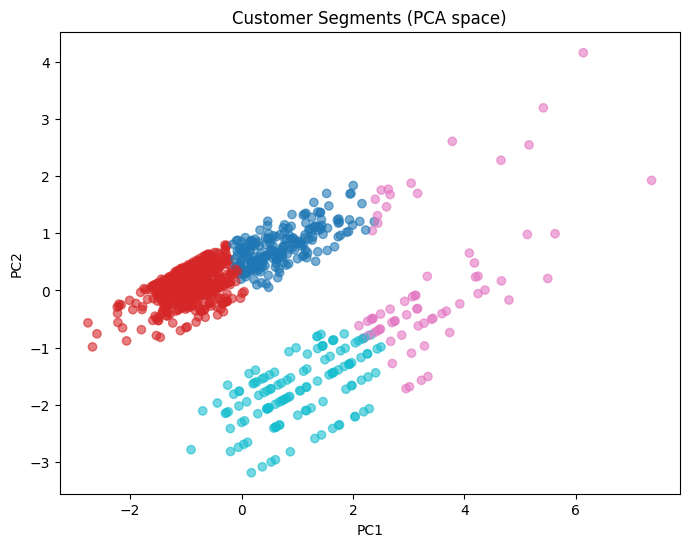

In [32]:
# Visualising Cluster
plt.figure(figsize=(8,6))
plt.scatter(
    rfm_pca[:, 0],
    rfm_pca[:, 1],
    c=rfm['Cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Segments (PCA space)")
plt.show()


In [33]:
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,26.898058,2.165049,971.223883
1,30.822898,1.041145,267.382594
2,7.985294,5.558824,3640.300735
3,3.328125,1.468750,643.511484


In [34]:
# 🔹 Clustering customers using GMM

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
rfm['GMM_Cluster'] = gmm.fit_predict(rfm_scaled)


In [35]:
# Calculating Silhouette Score

from sklearn.metrics import silhouette_score

kmeans_labels = rfm['Cluster']
gmm_labels = rfm['GMM_Cluster']

sil_kmeans = silhouette_score(rfm_scaled, kmeans_labels)
sil_gmm = silhouette_score(rfm_scaled, gmm_labels)

print(f"KMeans Silhouette: {sil_kmeans:.3f}")
print(f"GMM Silhouette: {sil_gmm:.3f}")


KMeans Silhouette: 0.470
GMM Silhouette: 0.469


In [36]:
# Calculating DB Index

from sklearn.metrics import davies_bouldin_score

db_kmeans = davies_bouldin_score(rfm_scaled, kmeans_labels)
db_gmm = davies_bouldin_score(rfm_scaled, gmm_labels)

print(f"KMeans DB Index: {db_kmeans:.3f}")
print(f"GMM DB Index: {db_gmm:.3f}")


KMeans DB Index: 0.886
GMM DB Index: 0.956


In [37]:
scores = []

for seed in [0, 10, 42, 99]:
    km = KMeans(n_clusters=4, random_state=seed, n_init=10)
    labels = km.fit_predict(rfm_scaled)
    scores.append(silhouette_score(rfm_scaled, labels))

scores


[np.float64(0.4699091842582204),
 np.float64(0.47168681136818746),
 np.float64(0.4699091842582204),
 np.float64(0.4699091842582204)]

In [38]:
kmeans.cluster_centers_


array([[ 0.34804264,  0.66048498,  0.71584127],
       [ 0.50987503, -0.52609216, -0.53090601],
       [-1.45434905,  2.40467762,  1.8969816 ],
       [-2.01422803, -0.0429099 ,  0.15873754]])

In [39]:
gmm.means_

array([[ 0.50555427, -0.5743787 , -0.4117762 ],
       [-1.81502256,  2.13029785,  1.77222557],
       [ 0.34093278,  0.94192746,  0.52198079],
       [-1.95777069,  0.15574812,  0.24412747]])

In [40]:
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary,GMM_Cluster
Cluster,,,,
0,26.898058,2.165049,971.223883,1.650485
1,30.822898,1.041145,267.382594,0.082290
2,7.985294,5.558824,3640.300735,1.632353
3,3.328125,1.468750,643.511484,2.906250


In [41]:
rfm.groupby('GMM_Cluster').mean()


,Recency,Frequency,Monetary,Cluster
GMM_Cluster,,,,
0,30.715035,1.000000,335.028199,0.937063
1,5.979167,6.208333,4306.254792,2.125000
2,26.752475,2.440594,928.734158,0.202970
3,3.453237,1.661871,672.721223,2.877698


In [42]:
rfm_pca_df = pd.DataFrame(
    rfm_pca,
    columns=['PC1', 'PC2'],
    index=rfm.index
)

rfm = pd.concat([rfm, rfm_pca_df], axis=1)


In [43]:
rfm['Cluster'].value_counts().sort_index()


,count
Cluster,
0,206
1,559
2,68
3,128


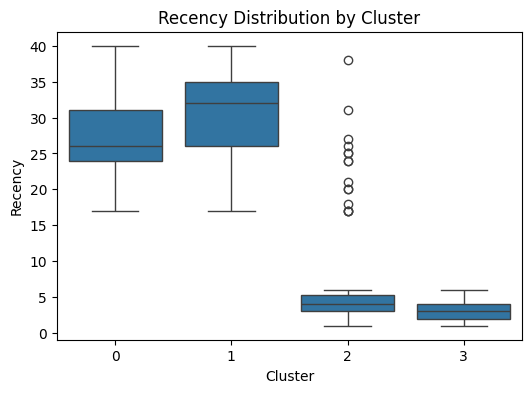

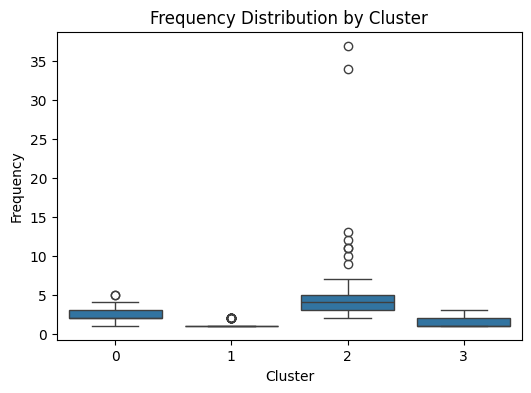

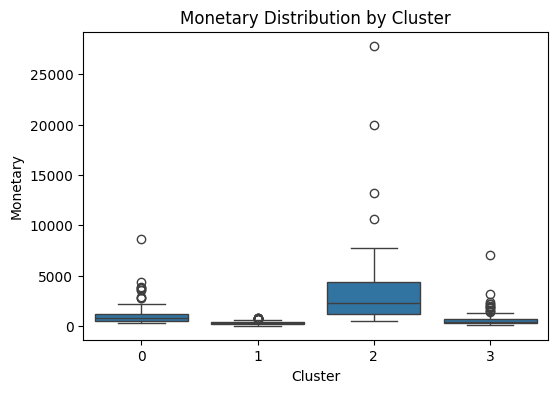

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['Recency', 'Frequency', 'Monetary']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Cluster', y=col, data=rfm)
    plt.title(f"{col} Distribution by Cluster")
    plt.show()


In [45]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
})

cluster_profile


Recency        Frequency            Monetary          
              mean median      mean median         mean    median
Cluster                                                          
0        26.898058   26.0  2.165049    2.0   971.223883   750.495
1        30.822898   32.0  1.041145    1.0   267.382594   247.380
2         7.985294    4.0  5.558824    4.0  3640.300735  2248.395
3         3.328125    3.0  1.468750    1.0   643.511484   425.425

In [46]:
cluster_profile_norm = (
    rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']]
    .mean()
    .apply(lambda x: (x - x.min()) / (x.max() - x.min()))
)

cluster_profile_norm


,Recency,Frequency,Monetary
Cluster,,,
0,0.857251,0.248779,0.208674
1,1.000000,0.000000,0.000000
2,0.169384,1.000000,1.000000
3,0.000000,0.094652,0.111514


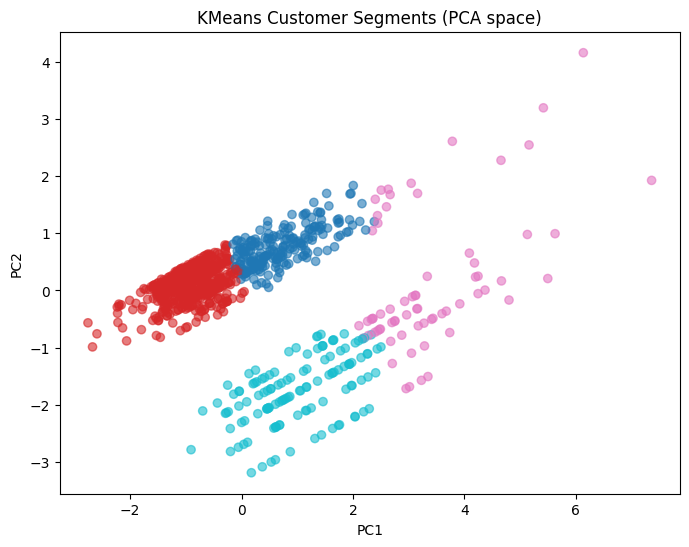

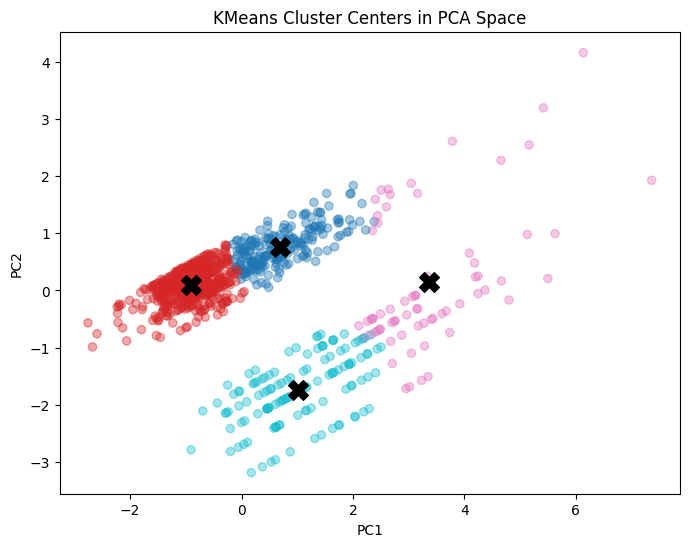

In [47]:
# ------------------------------
# KMeans PCA visualization
# ------------------------------

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#  Project scaled RFM to 2D PCA (for plotting)
pca_vis = PCA(n_components=2)
rfm_pca_vis = pca_vis.fit_transform(rfm_scaled)

#  Plotting clusters using existing kmeans.labels_
plt.figure(figsize=(8,6))
plt.scatter(
    rfm_pca_vis[:,0],
    rfm_pca_vis[:,1],
    c=rfm['Cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Customer Segments (PCA space)")
plt.show()

#  Plotting cluster centers
centers_pca = pca_vis.transform(kmeans.cluster_centers_)
plt.figure(figsize=(8,6))
plt.scatter(
    rfm_pca_vis[:,0],
    rfm_pca_vis[:,1],
    c=rfm['Cluster'],
    cmap='tab10',
    alpha=0.4
)
plt.scatter(
    centers_pca[:,0],
    centers_pca[:,1],
    c='black',
    s=200,
    marker='X'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Cluster Centers in PCA Space")
plt.show()


📊 Visualizing clusters in PCA space...


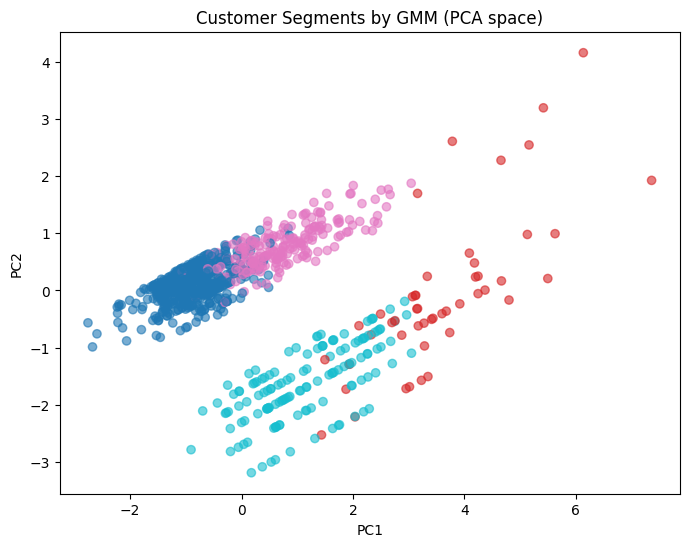

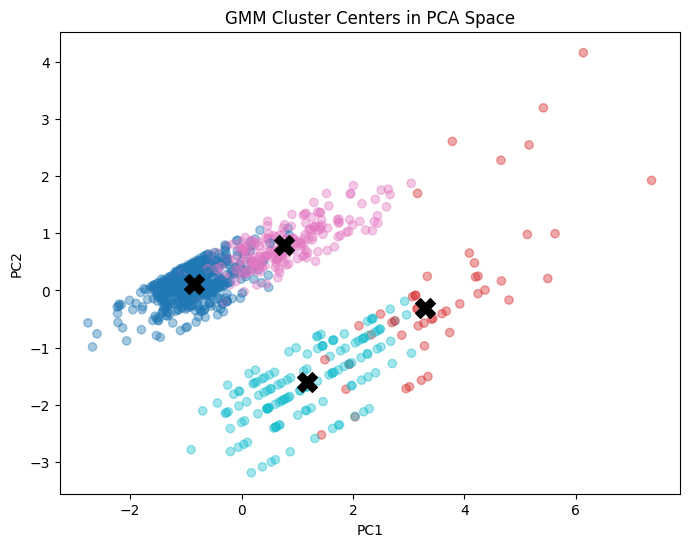

In [48]:
print("📊 Visualizing clusters in PCA space...")


# ------------------------------
# GMM Visualization
# ------------------------------

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=4, random_state=42)
rfm['GMM_Cluster'] = gmm.fit_predict(rfm_scaled)

pca_gmm = PCA(n_components=2)
rfm_pca_gmm = pca_gmm.fit_transform(rfm_scaled)

#  Plotting GMM clusters
plt.figure(figsize=(8,6))
plt.scatter(
    rfm_pca_gmm[:,0],
    rfm_pca_gmm[:,1],
    c=rfm['GMM_Cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Segments by GMM (PCA space)")
plt.show()

#  Plotting GMM cluster centers in PCA space
gmm_centers_pca = pca_gmm.transform(gmm.means_)
plt.figure(figsize=(8,6))
plt.scatter(
    rfm_pca_gmm[:,0],
    rfm_pca_gmm[:,1],
    c=rfm['GMM_Cluster'],
    cmap='tab10',
    alpha=0.4
)
plt.scatter(
    gmm_centers_pca[:,0],
    gmm_centers_pca[:,1],
    c='black',
    s=200,
    marker='X'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("GMM Cluster Centers in PCA Space")
plt.show()
